In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from datetime import datetime
from math import *
from scipy import optimize
import datetime
from scipy.interpolate import make_interp_spline, BSpline
import scipy as sp
from numpy import linalg as LA

In [33]:
bonds = pd.read_excel('./data/selected_bonds_2022-01-13.xlsx', sheet_name='Sheet3', parse_dates=['Issue Date', 'Maturity Date'])
print(bonds)

        Name          ISIN  Coupon Issue Date Maturity Date
0   CDA 2022  CA135087G328  0.0050 2016-10-11    2022-03-01
1   CDA 2022  CA135087L369  0.0025 2020-08-17    2022-11-01
2   CDA 2023  CA135087L856  0.0025 2021-02-04    2023-04-30
3   CDA 2023  CA135087M763  0.0050 2021-08-08    2023-10-31
4   CDA 2024  CA135087L690  0.0025 2020-10-16    2024-04-01
5   CDA 2024  CA135087M508  0.0075 2021-07-11    2024-09-30
6   CDA 2025  CA135087K528  0.0125 2019-10-10    2025-02-28
7   CDA 2025  CA135087K940  0.0050 2020-04-02    2025-08-31
8   CDA 2026  CA135087L518  0.0025 2020-10-08    2026-02-28
9   CDA 2026  CA135087L930  0.0100 2021-04-16    2026-09-01
10  CDA 2027  CA135087M847  0.0125 2021-10-15    2027-03-01


In [34]:
close = pd.read_excel('./data/selected_close_2022-01-13.xlsx', parse_dates=['Date'], sheet_name='Sheet3')
print(close)

        Date  3/1/2022  11/1/2022  4/30/2023  10/31/2023  4/1/2024  9/30/2024  \
0 2022-01-10    100.04      99.55      99.08      98.968     97.96     98.555   
1 2022-01-11    100.03      99.54      99.07      98.955     97.96     98.560   
2 2022-01-12    100.03      99.52      99.05      98.934     97.93     98.530   
3 2022-01-13    100.03      99.52      99.04      98.911     97.90     98.485   
4 2022-01-14    100.02      99.50      99.01      98.878     97.86     98.440   
5 2022-01-15    100.02      99.43      98.90      98.732     97.68     98.205   
6 2022-01-16    100.00      99.40      98.85      98.666     97.61     98.115   
7 2022-01-17    100.00      99.42      98.87      98.654     97.60     98.125   
8 2022-01-18    100.00      99.43      98.87      98.661     97.60     98.140   
9 2022-01-19    100.01      99.46      98.92      98.717     97.71     98.275   

   2/28/2025  8/31/2025  2/28/2026  9/1/2026  3/1/2027  
0      99.64      96.66      95.11    97.660    98.

        Name          ISIN  Coupon Issue Date Maturity Date       ttm
0   CDA 2022  CA135087G328  0.0050 2016-10-11    2022-03-01  0.136986
1   CDA 2022  CA135087L369  0.0025 2020-08-17    2022-11-01  0.808219
2   CDA 2023  CA135087L856  0.0025 2021-02-04    2023-04-30  1.301370
3   CDA 2023  CA135087M763  0.0050 2021-08-08    2023-10-31  1.805479
4   CDA 2024  CA135087L690  0.0025 2020-10-16    2024-04-01  2.224658
5   CDA 2024  CA135087M508  0.0075 2021-07-11    2024-09-30  2.723288
6   CDA 2025  CA135087K528  0.0125 2019-10-10    2025-02-28  3.136986
7   CDA 2025  CA135087K940  0.0050 2020-04-02    2025-08-31  3.641096
8   CDA 2026  CA135087L518  0.0025 2020-10-08    2026-02-28  4.136986
9   CDA 2026  CA135087L930  0.0100 2021-04-16    2026-09-01  4.643836
10  CDA 2027  CA135087M847  0.0125 2021-10-15    2027-03-01  5.139726
Bond 0: 0.01517536347431509
Bond 1: 0.008670465798614444
Bond 2: 0.009988930246409474
Bond 3: 0.011298147451468017
Bond 4: 0.012096375499746004
Bond 5: 0.013647

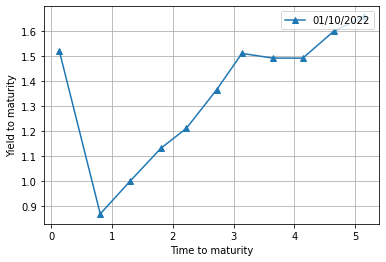

(<matplotlib.legend.Legend at 0x12e9e8c10>, None)

In [35]:
tr, yr = [], []
today = datetime.datetime(2022, 1, 10)
bonds['ttm'] = [(maturity - today).days / 365 for maturity in bonds['Maturity Date']]
bonds = bonds.sort_values(by=['ttm'])
print(bonds)

for i, bond in bonds.iterrows():
    par = 100
    ttm = bond['ttm']
    coupon = par * bond['Coupon'] / 2. # semi-annual coupon payment
    price = (0.5 - ttm % 0.5) * bond['Coupon'] + close.iloc[close.loc[close['Date'] == today].index[0], i+1]
    def RHS_func(ytm): # ttm, coupon, par, PRICE
        if ttm <= (ttm % 0.5): # zero-coupon bond maturing soon
            return (coupon + par) * np.exp(- ttm * ytm) - price
        else: # non-zero-coupon bonds
            temp = 0
            for j in np.arange(ttm, 0, -0.5):
                temp += coupon * np.exp(- j * ytm)
            return temp + par * np.exp(- ttm * ytm) - price
    ytm = optimize.newton(RHS_func, 0.01)
    print('Bond ' + str(i) + ': ' + str(ytm))
    tr.append(ttm)
    yr.append(ytm)

bonds['ytm'] = yr
print(bonds)
xlabel('Time to maturity'), ylabel('Yield to maturity'), grid(True)
plot(tr, np.array(yr)*100, marker='^', label=today.strftime("%m/%d/%Y"))
legend(loc='upper right'), show()

        Name          ISIN  Coupon Issue Date Maturity Date       ttm  \
0   CDA 2022  CA135087G328  0.0050 2016-10-11    2022-03-01  0.136986   
1   CDA 2022  CA135087L369  0.0025 2020-08-17    2022-11-01  0.808219   
2   CDA 2023  CA135087L856  0.0025 2021-02-04    2023-04-30  1.301370   
3   CDA 2023  CA135087M763  0.0050 2021-08-08    2023-10-31  1.805479   
4   CDA 2024  CA135087L690  0.0025 2020-10-16    2024-04-01  2.224658   
5   CDA 2024  CA135087M508  0.0075 2021-07-11    2024-09-30  2.723288   
6   CDA 2025  CA135087K528  0.0125 2019-10-10    2025-02-28  3.136986   
7   CDA 2025  CA135087K940  0.0050 2020-04-02    2025-08-31  3.641096   
8   CDA 2026  CA135087L518  0.0025 2020-10-08    2026-02-28  4.136986   
9   CDA 2026  CA135087L930  0.0100 2021-04-16    2026-09-01  4.643836   
10  CDA 2027  CA135087M847  0.0125 2021-10-15    2027-03-01  5.139726   

         ytm  
0   0.015175  
1   0.008670  
2   0.009989  
3   0.011298  
4   0.012096  
5   0.013647  
6   0.015093  
7  

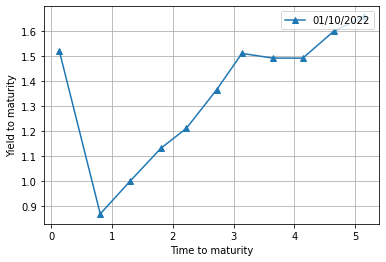

(<matplotlib.legend.Legend at 0x12e9a5a60>, None)

In [36]:
tr, yr = [], []
today = datetime.datetime(2022, 1, 10)
bonds['ttm'] = [(maturity - today).days / 365 for maturity in bonds['Maturity Date']]
bonds = bonds.sort_values(by=['ttm'])
print(bonds)

for i, bond in bonds.iterrows():
    par = 100
    ttm = bond['ttm']
    coupon = par * bond['Coupon'] / 2. # semi-annual coupon payment
    price = (0.5 - ttm % 0.5) * bond['Coupon'] + close.iloc[close.loc[close['Date'] == today].index[0], i+1]
    def RHS_func(ytm): # ttm, coupon, par, PRICE
      if ttm <= (ttm % 0.5): # zero-coupon bond maturing soon
        return (coupon + par) * np.exp(- ttm * ytm) - price
      else: # non-zero-coupon bonds
        temp = 0
        for j in np.arange(ttm, 0, -0.5):
          temp += coupon * np.exp(- j * ytm)
        return temp + par * np.exp(- ttm * ytm) - price
    ytm = optimize.newton(RHS_func, 0.01)
    print('Bond ' + str(i) + ': ' + str(ytm))
    tr.append(ttm)
    yr.append(ytm)

bonds['ytm'] = yr
print(bonds)
xlabel('Time to maturity'), ylabel('Yield to maturity'), grid(True)
plot(tr, np.array(yr)*100, marker='^', label=today.strftime("%m/%d/%Y"))
legend(loc='upper right'), show()

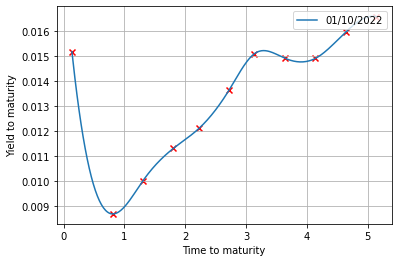

In [37]:
ts = np.linspace(min(tr), max(tr), 300)
spl = make_interp_spline(tr, yr, k=3)
ys = spl(ts)

xlabel('Time to maturity'), ylabel('Yield to maturity'), grid(True)
plt.plot(ts, ys, label=today.strftime("%m/%d/%Y"))
plt.scatter(tr, yr, marker='x', color='red')
legend(loc='upper right')
plt.show()

#### Superimposed yield curve

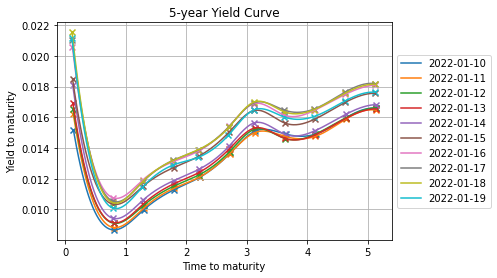

In [38]:
for today in close['Date']:
  tr, yr = [], []
  # today = datetime.datetime(2022, 1, 10)
  bonds['ttm'] = [(maturity - today).days / 365 for maturity in bonds['Maturity Date']]
  bonds = bonds.sort_values(by=['ttm'])
  # print(bonds)


  for i, bond in bonds.iterrows():
      par = 100
      ttm = bond['ttm']
      coupon = par * bond['Coupon']/2 # semi-annual coupon payment
      price = (0.5 - ttm % 0.5) * bond['Coupon'] + close.iloc[close.loc[close['Date'] == today].index[0], i+1]
      def RHS_func(ytm): # ttm, coupon, par, PRICE
        if ttm <= (ttm % 0.5): # zero-coupon bond maturing soon
          return (coupon + par) * np.exp(- ttm * ytm) - price
        else: # non-zero-coupon bonds
          temp = 0
          for j in np.arange(ttm, 0, -0.5):
            temp += coupon * np.exp(- j * ytm)
          return temp + par * np.exp(- ttm * ytm) - price
      ytm = optimize.newton(RHS_func, 0.01)
      # print('Bond ' + str(i) + ': ' + str(ytm))
      tr.append(ttm)
      yr.append(ytm)


  ts = np.linspace(min(tr), max(tr), 300)
  spl = make_interp_spline(tr, yr, k=3)
  ys = spl(ts)

  xlabel('Time to maturity'), ylabel('Yield to maturity'), grid(True)
  plt.plot(ts, ys, label=today.strftime("%Y-%m-%d"))
  legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.scatter(tr, yr, marker='x')
plt.title('5-year Yield Curve')
plt.show()

#### Construct spot rate treasury curve

The bootstrapping method is built on the following:


*   For $0 < t_{1} < \frac{1}{2}$
$$P(0, t_{1}) = (Coupon + Par) \cdot e^{-r(t_{1}) \cdot t_{1}}$$
*   For $0 < t_{1} < \frac{1}{2} < t_{2} < 1$
$$P(0, t_{2}) = Coupon \cdot e^{-r(t_{1}) \cdot t_{1}} + (Coupon + Par) \cdot e^{-r(t_{2}) \cdot t_{2}}$$
*   For $0 < t_{1} < \frac{1}{2} < t_{2} < 1 < t_{3} < \frac{3}{2}$
$$P(0, t_{2}) = Coupon \cdot e^{-r(t_{1}) \cdot t_{1}} + Coupon \cdot e^{-r(t_{2}) \cdot t_{2}} + (Coupon + Par) \cdot e^{-r(t_{3}) \cdot t_{3}}$$
*   $\cdots$
*   For all $t_{i} \in \{TTM, TTM-0.5, TTM-1, ..., TTM \bmod 0.5\}$ 

Hence the pseudo code is

    Create an empty list storing time to maturity;
    Create an empty list storing calculated spot rates;
    for each bond:
      Get its timeToMaturity from the current date;
      Calculate its semi-annual coupon;
      Calculate its dirty price;
      
      # Bootstrapping Spot Curve
      couponSum = 0;
      if ttm > (ttm % 0.5): # non-zero-coupon bonds
        for j in TTM-0.5, TTM-1, ..., TTM mod 0.5:
          couponSum += discounted coupons by the spot rate on day j;
      spot = - log((dirtyPrice - couponSum) / (coupon + par)) / timeToMaturity;
      
      Store current timeToMaturity into list;
      Store current spot rate into list;
    Plot the spot rate curve with interpolation.
Repeat the above procedure for data of each day and then superimpose the plots.

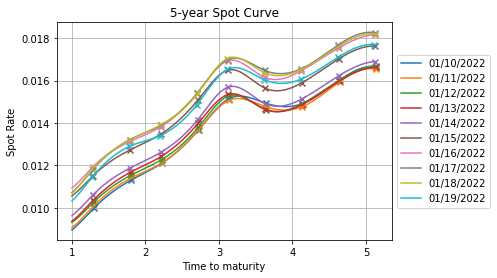

In [39]:
# Superimpose spot curves
for today in close['Date']:
    tr, rr = [], []
    # today = datetime.datetime(2022, 1, 10)
    bonds['ttm'] = [(maturity - today).days / 365 for maturity in bonds['Maturity Date']]
    bonds = bonds.sort_values(by=['ttm'])
    # print(bonds)

    for i, bond in bonds.iterrows():
        par = 100
        ttm = bond['ttm']
        coupon = par * bond['Coupon'] / 2.  # semi-annual coupon payment
        price = (0.5 - ttm % 0.5) * bond['Coupon'] + close.iloc[close.loc[close['Date'] == today].index[0], i + 1]

        # Bootstrap
        couponSum = 0

        if ttm > (ttm % 0.5):  # non-zero-coupon bonds
            for j in np.arange(ttm - 0.5, 0, -0.5):
                couponSum += coupon * np.exp(- rr[int(j // 0.5)] * j)

        spot = - np.log((price - couponSum) / (coupon + par)) / ttm
        # print('Bond ' + str(i) + ': ' + str(spot))
        tr.append(ttm)
        rr.append(spot)

    ts = np.linspace(1, max(tr), 300)
    spl = make_interp_spline(tr, rr, k=3)
    rs = spl(ts)

    xlabel('Time to maturity'), ylabel('Spot Rate'), grid(True)
    plt.plot(ts, rs, label=today.strftime("%m/%d/%Y"))
    legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.scatter(np.delete(tr, [0, 1]), np.delete(rr, [0, 1]), marker='x')
plt.title('5-year Spot Curve')
plt.show()

#### Construct forward rate treasury curve

Forward rates are calculated from spot rates.

$$Forward Rate= \frac{(1+r_{2})^{t_{2}}}{(1+r_{1})^{t_{1}}} − 1$$
where:<br>
$r_{2} = $ The spot rate for the bond of term $t_{2}$ periods
<br>
$r_{1} = $ The spot rate for the bond of term $t_{1}$ periods with $t_{1} < t_{2}$

The pseudo code is

    for data of each day do
        Repeat algorithm 1 to generate enough points {(t1, r1), (t2, r2), ...} from the spot curve
        for each point do 
            derive forward rate by f(0, t1, t2) = (1+r2)^t2/(1+r1)^t1 -1
        end 
        Plot the forward rate curve over the required interval
    end

Repeat the above procedure for data of each day and then superimpose the plots.

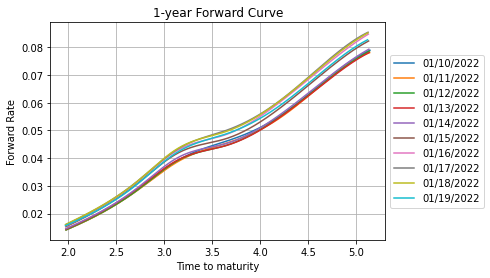

In [40]:
# Superimpose Forward Curves
for today in close['Date']:
    tr, rr = [], []
    # today = datetime.datetime(2022, 1, 10)
    bonds['ttm'] = [(maturity - today).days / 365 for maturity in bonds['Maturity Date']]
    bonds = bonds.sort_values(by=['ttm'])
    # print(bonds)

    for i, bond in bonds.iterrows():
        par = 100
        ttm = bond['ttm']
        coupon = par * bond['Coupon'] / 2.  # semi-annual coupon payment
        price = (0.5 - ttm % 0.5) * bond['Coupon'] + close.iloc[close.loc[close['Date'] == today].index[0], i + 1]

        # Bootstrap
        couponSum = 0

        if ttm > (ttm % 0.5):  # non-zero-coupon bonds
            for j in np.arange(ttm - 0.5, 0, -0.5):
                couponSum += coupon * np.exp(- rr[int(j // 0.5)] * j)

        spot = - np.log((price - couponSum) / (coupon + par)) / ttm
        # print('Bond ' + str(i) + ': ' + str(spot))
        tr.append(ttm)
        rr.append(spot)

    ts = np.linspace(1, max(tr), 300)
    spl = make_interp_spline(tr, rr, k=3)
    rs = spl(ts)

    tfs, fs = [], []
    r1 = rs[0]  # Construct 1-year forward curve
    t1 = 1
    for i in range(np.where(ts > 1.97)[0][0], 300):  # Term ranges from 2 to 5 years
        temp = (1 + rs[i]) ** ts[i] / (1 + r1) ** t1 - 1
        tfs.append(ts[i])
        fs.append(temp)

    xlabel('Time to maturity'), ylabel('Forward Rate'), grid(True)
    plt.plot(tfs, fs, label=today.strftime("%m/%d/%Y"))
    legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('1-year Forward Curve')
plt.show()

#### Time series and covariance matrices

In [41]:
# First, we obtain the time series of i-year yield for i = 1, . . . , 5.
list_2d = []

for today in close['Date']:
  tr, yr = [], []
  # today = datetime.datetime(2022, 1, 10)
  bonds['ttm'] = [(maturity - today).days / 365 for maturity in bonds['Maturity Date']]
  bonds = bonds.sort_values(by=['ttm'])
  # print(bonds)

  for i, bond in bonds.iterrows():
      par = 100
      ttm = bond['ttm']
      coupon = par * bond['Coupon'] / 2 # semi-annual coupon payment
      price = (0.5 - ttm % 0.5) * bond['Coupon'] + close.iloc[close.loc[close['Date'] == today].index[0], i+1]
      def RHS_func(ytm): # ttm, coupon, par, PRICE
        if ttm <= (ttm % 0.5): # zero-coupon bond maturing soon
          return (coupon + par) * np.exp(-ttm * ytm) - price
        else: # non-zero-coupon bonds
          temp = 0
          for j in np.arange(ttm, 0, -0.5):
            temp += coupon * np.exp(-j * ytm)
          return temp + par * np.exp(-ttm * ytm) - price
      ytm = optimize.newton(RHS_func, 0.01)
      # print('Bond ' + str(i) + ': ' + str(ytm))
      tr.append(ttm)
      yr.append(ytm)


  ts = np.linspace(1, max(tr), 300)
  spl = make_interp_spline(tr, yr, k=3)
  ys = spl(ts)

  ya = []
  for i in [np.where(ts > 0.97)[0][0], np.where(ts > 1.97)[0][0], np.where(ts > 2.97)[0][0], np.where(ts > 3.97)[0][0], np.where(ts > 4.97)[0][0]]:
    ya.append(ys[i])
  list_2d.append(ya)

column_names = [str(i) + '-year yield' for i in [1, 2, 3, 4, 5]]
df_yield_raw = pd.DataFrame(list_2d, columns = column_names)
print(df_yield_raw)

   1-year yield  2-year yield  3-year yield  4-year yield  5-year yield
0      0.008954      0.011622      0.014666      0.014775      0.016545
1      0.009065      0.011684      0.014622      0.014617      0.016457
2      0.009310      0.011835      0.014838      0.014654      0.016526
3      0.009365      0.011986      0.014965      0.014627      0.016470
4      0.009627      0.012193      0.015262      0.014904      0.016732
5      0.010556      0.013036      0.016115      0.015648      0.017504
6      0.010938      0.013408      0.016533      0.016215      0.018003
7      0.010723      0.013510      0.016530      0.016379      0.018184
8      0.010690      0.013511      0.016616      0.016314      0.018101
9      0.010321      0.013128      0.016098      0.015907      0.017597


In [42]:
# Then we calculate the daily log-returns & the required covariance matrix
# Note that our original data has dates in reverse chronological order
df_yield = pd.DataFrame()
for i in [1, 2, 3, 4, 5]:
    df_yield[str(i) + '-year yield log'] = np.log(df_yield_raw[str(i) + '-year yield'].shift(1)) - np.log(df_yield_raw[str(i) + '-year yield'])

df_yield = df_yield.dropna(axis = 0)
print(df_yield)
print(df_yield.cov())

   1-year yield log  2-year yield log  3-year yield log  4-year yield log  \
1         -0.012266         -0.005266          0.003051          0.010753   
2         -0.026682         -0.012853         -0.014724         -0.002515   
3         -0.005916         -0.012690         -0.008526          0.001825   
4         -0.027597         -0.017107         -0.019605         -0.018719   
5         -0.092114         -0.066893         -0.054387         -0.048725   
6         -0.035551         -0.028085         -0.025606         -0.035619   
7          0.019886         -0.007573          0.000188         -0.010020   
8          0.003043         -0.000127         -0.005189          0.003935   
9          0.035137          0.028753          0.031625          0.025270   

   5-year yield log  
1          0.005304  
2         -0.004200  
3          0.003412  
4         -0.015772  
5         -0.045122  
6         -0.028088  
7         -0.010023  
8          0.004559  
9          0.028244  
         

In [43]:
# Similarly for forward rates 1yr-1yr, 1yr-2yr, 1yr-3yr, 1yr-4yr.
list_2d = []

for today in close['Date']:
  tr, rr = [], []
  # today = datetime.datetime(2022, 1, 10)
  bonds['ttm'] = [(maturity - today).days / 365 for maturity in bonds['Maturity Date']]
  bonds = bonds.sort_values(by=['ttm'])
  # print(bonds)


  for i, bond in bonds.iterrows():
      par = 100
      ttm = bond['ttm']
      coupon = par * bond['Coupon'] / 2. # semi-annual coupon payment
      price = (0.5 - ttm % 0.5) * bond['Coupon'] + close.iloc[close.loc[close['Date'] == today].index[0], i+1]
      
      # Bootstrap
      couponSum = 0

      if ttm > (ttm % 0.5): #non-zero-coupon bonds
        for j in np.arange(ttm - 0.5, 0, -0.5):
          couponSum += coupon * np.exp(- rr[int(j//0.5)] * j)
    
      spot = - np.log((price - couponSum) / (coupon + par)) / ttm
      #print('Bond ' + str(i) + ': ' + str(spot))
      tr.append(ttm)
      rr.append(spot)


  ts = np.linspace(1, max(tr), 300)
  spl = make_interp_spline(tr, rr, k=3)
  rs = spl(ts)

  tfs, fs = [], []
  r1 = rs[0] # Construct 1-year forward curve
  t1 = 1
  for i in range(np.where(ts > 1.97)[0][0], 300): # Term ranges from 2 to 5 years
    temp = (1+rs[i])**ts[i] / (1+r1)**t1 - 1
    tfs.append(ts[i])
    fs.append(temp)

  fa = []
  for i in [np.where(np.asarray(tfs) > 1.97)[0][0], np.where(np.asarray(tfs) > 2.97)[0][0], np.where(np.asarray(tfs) > 3.97)[0][0], np.where(np.asarray(tfs) > 4.97)[0][0]]:
    fa.append(fs[i])
  list_2d.append(fa)

column_names = ['1yr-' + str(i) + '-yr' for i in [1, 2, 3, 4]]
df_forward_raw = pd.DataFrame(list_2d, columns = column_names)
print(df_forward_raw)

   1yr-1-yr  1yr-2-yr  1yr-3-yr  1yr-4-yr
0  0.014108  0.035213  0.050672  0.075794
1  0.014111  0.034939  0.049874  0.075161
2  0.014157  0.035329  0.049737  0.075464
3  0.014394  0.035636  0.049538  0.075043
4  0.014533  0.036251  0.050585  0.076096
5  0.015265  0.037864  0.052654  0.079121
6  0.015608  0.038721  0.054568  0.081303
7  0.016019  0.038911  0.055436  0.082718
8  0.016047  0.039426  0.055169  0.082257
9  0.015650  0.038202  0.053844  0.079924


In [44]:
df_forward = pd.DataFrame()
for i in [1, 2, 3, 4]:
    df_forward['1yr-' + str(i) + '-yr log'] = np.log(df_forward_raw['1yr-' + str(i) + '-yr'].shift(1)) - np.log(df_forward_raw['1yr-' + str(i) + '-yr'])

df_forward = df_forward.dropna(axis = 0)
print(df_forward)
print(df_forward.cov())

   1yr-1-yr log  1yr-2-yr log  1yr-3-yr log  1yr-4-yr log
1     -0.000192      0.007829      0.015879      0.008382
2     -0.003248     -0.011098      0.002749     -0.004022
3     -0.016605     -0.008669      0.004017      0.005598
4     -0.009606     -0.017093     -0.020928     -0.013941
5     -0.049145     -0.043552     -0.040075     -0.038980
6     -0.022260     -0.022361     -0.035705     -0.027202
7     -0.025995     -0.004915     -0.015786     -0.017255
8     -0.001702     -0.013133      0.004823      0.005589
9      0.025044      0.031538      0.024316      0.028775
              1yr-1-yr log  1yr-2-yr log  1yr-3-yr log  1yr-4-yr log
1yr-1-yr log      0.000425      0.000373      0.000400      0.000390
1yr-2-yr log      0.000373      0.000425      0.000399      0.000381
1yr-3-yr log      0.000400      0.000399      0.000506      0.000451
1yr-4-yr log      0.000390      0.000381      0.000451      0.000427


#### PCA

In [45]:
w, v = LA.eig(df_yield.cov())
print(w, v)
print('The first principal component of the yields is: ', v[np.argmax(w)])

[3.31999155e-03 1.62258366e-04 2.55591798e-05 3.15112959e-06
 1.45027802e-05] [[-0.61915706  0.67425467 -0.39880138 -0.02841557 -0.04663893]
 [-0.43456317 -0.05279938  0.63874864  0.22320047 -0.59207162]
 [-0.39959251 -0.03833849  0.46530511 -0.02726325  0.78841858]
 [-0.37727547 -0.58112459 -0.44427654  0.56453581  0.06225035]
 [-0.35466666 -0.451018   -0.13808385 -0.79368138 -0.1476382 ]]
The first principal component of the yields is:  [-0.61915706  0.67425467 -0.39880138 -0.02841557 -0.04663893]


In [46]:
w, v = LA.eig(df_forward.cov())
print(w, v)
print('The first principal component of the forward rates is: ', v[np.argmax(w)])

[1.64593266e-03 9.08810988e-06 5.28149133e-05 7.55886109e-05] [[-0.48190484 -0.21310411 -0.7331527  -0.42993194]
 [-0.47870736 -0.03985445  0.66296936 -0.57421469]
 [-0.53537707 -0.53695575  0.13380156  0.63808077]
 [-0.50197449  0.81527712 -0.07110472  0.27980162]]
The first principal component of the forward rates is:  [-0.48190484 -0.21310411 -0.7331527  -0.42993194]
